In [4]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize as wtoken
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import (Activation, Dropout, Dense, Embedding, Flatten, BatchNormalization, GlobalMaxPooling1D, Lambda, concatenate, LSTM, Concatenate)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os, string, gc, re

from tqdm import tqdm


import tldextract as tld


from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.0.0
Num GPUs Available:  1


In [6]:
def test_tf_gpu():
    tf.debugging.set_log_device_placement(True)
    # Create some tensors
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)
    print(c)

In [4]:
features = ['question_title', 'question_body', 'answer']

In [5]:
train = pd.read_csv('../kaggle/input/google-quest-challenge/train.csv', usecols = features)
test = pd.read_csv('../kaggle/input/google-quest-challenge/test.csv', usecols = features)
submission = pd.read_csv('../kaggle/input/google-quest-challenge/sample_submission.csv')

In [6]:
Y =  pd.read_csv('../kaggle/input/google-quest-challenge/train.csv', usecols = submission.columns.values)
Y.pop('qa_id');

In [7]:
train.shape

(6079, 3)

In [8]:
test.shape

(476, 3)

# For pre-processing uniformality, test data will be appended to train data without reindexing.

In [9]:
X = train.append(test)

In [10]:
X.head(2)

,question_title,question_body,answer
0,What am I losing when using extension tubes in...,After playing around with macro photography on...,"I just got extension tubes, so here's the skin..."
1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,It might be helpful to look into the definitio...


In [11]:
Y.head(2)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,1.0,0.333333,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.0,0.000000,1.000000
1,1.0,1.000000,0.0,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.0,0.666667,0.888889


In [12]:
Y.shape

(6079, 30)

# Convert all words to lower, this helps when using NLTK functions since they are use lower case words, e.g. the stopwords list.

In [13]:
for f in tqdm(X.columns.values):
    X[f] = X[f].str.lower()

100%|██████████| 3/3 [00:00<00:00, 83.19it/s]


In [14]:
X.head(2)

,question_title,question_body,answer
0,what am i losing when using extension tubes in...,after playing around with macro photography on...,"i just got extension tubes, so here's the skin..."
1,what is the distinction between a city and a s...,i am trying to understand what kinds of places...,it might be helpful to look into the definitio...


# Word based Tokenization with NLTK

In [15]:
tokenized_answer=[]

for doc in tqdm(X.answer):
    tokenized_answer.append(word_tokenize(doc))

100%|██████████| 6555/6555 [00:05<00:00, 1103.52it/s]


In [16]:
tokenized_question_body=[]
for doc in tqdm(X.question_body):
    tokenized_question_body.append(word_tokenize(doc))

100%|██████████| 6555/6555 [00:05<00:00, 1185.97it/s]


In [17]:
tokenized_question_title=[]
for doc in tqdm(X.question_title):
    tokenized_question_title.append(word_tokenize(doc))

100%|██████████| 6555/6555 [00:00<00:00, 10951.06it/s]


# Cleaning the text from non english alphabet, non meanningful characters and short/very long words

In [18]:
def remove_non_english(text):
    result = []
    
    for words in tqdm(text):
        result.append([x.replace(re.sub(r'[aA-zZ]',r'',x), '') for x in words])
    return result

In [19]:
def remove_nonalpha(text):
    
    result = []
    
    for w in tqdm(text):
        
        result.append([x for x in w if x.isalpha() and x.isascii()])
    
    return result

In [20]:
def remove_char(text, c=''):
    result = []
    for w in tqdm(text):
        result.append([x for x in w if x !=c])
    return result

In [21]:
def remove_long_words(pd_series):
    # expects a pandas Seires 
    # removes any word by its length range( 4-12 chars)
    # returns a list of strings
    result = []
    result = tqdm(pd_series.str.findall('\w{4,12}').str.join(' '))
    return result

In [22]:
def remove_words(text, min_length = 4, max_length = 12):
    result = []
    for w in tqdm(text):
        result.append([x for x in w if len(x) in range(min_length, max_length)])
    return result

In [23]:
tokenized_answer= remove_nonalpha(tokenized_answer)

X['answer'] = remove_char(tokenized_answer)

X['answer'] = remove_words(X['answer'])

100%|██████████| 6555/6555 [00:00<00:00, 32055.70it/s]


In [24]:
tokenized_question_body= remove_nonalpha(tokenized_question_body)

X['question_body'] = remove_char(tokenized_question_body)

X['question_body'] = remove_words(X['question_body'])

100%|██████████| 6555/6555 [00:00<00:00, 33118.99it/s]


In [25]:
tokenized_question_title= remove_nonalpha(tokenized_question_title)

X['question_title'] = remove_char(tokenized_question_title)

X['question_title'] = remove_words(X['question_title'])

100%|██████████| 6555/6555 [00:00<00:00, 278967.71it/s]


In [26]:
X.head(2)

,question_title,question_body,answer
0,"[what, losing, when, using, extension, tubes, ...","[after, playing, around, with, macro, photogra...","[just, extension, tubes, here, skinny, what, l..."
1,"[what, distinction, between, city, between, do...","[trying, understand, what, kinds, places, spam...","[might, helpful, look, into, definition, spam,..."


# Remvoing Stop words

In [27]:
stop_words = stopwords.words('english')
for f in tqdm(['question_title', 'question_body', 'answer']):
    X[f] = X[f].apply(lambda x: [word for word in x if word not in stop_words])

100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


In [28]:
X.head(2)

,question_title,question_body,answer
0,"[losing, using, extension, tubes, instead, mac...","[playing, around, macro, photography, read, re...","[extension, tubes, skinny, losing, using, tube..."
1,"[distinction, city, downtown, commercial, dist...","[trying, understand, kinds, places, spam, valu...","[might, helpful, look, definition, spam, zone,..."


In [29]:
lemmatizer = WordNetLemmatizer() 

for f in tqdm(X.columns):
     X[f] = X[f].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


In [30]:
print(X.head(3))

                                      question_title  \
0  [losing, using, extension, tube, instead, macr...   
1  [distinction, city, downtown, commercial, dist...   
2       [maximum, protusion, length, component, pin]   

                                       question_body  \
0  [playing, around, macro, photography, read, re...   
1  [trying, understand, kind, place, spam, value,...   
2  [working, component, side, board, side, board,...   

                                              answer  
0  [extension, tube, skinny, losing, using, tube,...  
1  [might, helpful, look, definition, spam, zone,...  
2  [even, need, groove, make, several, product, u...  


# Transformer universal-sentence-encoder-large/5

In [ ]:
# Cache the model
# embed = hub.load('../kaggle/input/google-quest-challenge/USE5')

embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')


In [ ]:
def universal_embedding(input):
    return embed(tf.squeeze((tf.cast(input, tf.string))))

# It looks like using swish activation is (sometimes) better than RELU in NLP Tasks
## Source (paper): https://www.aclweb.org/anthology/D18-1472.pdf

In [ ]:
def swish(x):
    return K.sigmoid(x) * x

# Extract train and test datasets back from X..

In [34]:
train = X.iloc[:train.shape[0], :]
gc.collect()
print(train.shape)
train.head(2)

(6079, 3)


,question_title,question_body,answer
0,"[losing, using, extension, tube, instead, macr...","[playing, around, macro, photography, read, re...","[extension, tube, skinny, losing, using, tube,..."
1,"[distinction, city, downtown, commercial, dist...","[trying, understand, kind, place, spam, value,...","[might, helpful, look, definition, spam, zone,..."


In [35]:
test = X.iloc[train.shape[0]:,:]
gc.collect()
print(test.shape)


(476, 3)


In [36]:
test.tail()

,question_title,question_body,answer
471,"[change, enumeration, chapter]","[using, glossing, example, thesis, would, like...","[simply, reset, counter, command, borrowed, li..."
472,"[anagram, file]","[source, microsoft, interview, question, given...","[slightly, different, approach, returning, has..."
473,"[server, time, series, table, design]","[creating, time, series, database, follows, ta...","[foreign, reference, unique, constraint, neces..."
474,"[countered, flashback, spell, exiled]","[flashback, past, flame, countered, cancel, ex...","[counter, spell, cast, flashback, cost, gravey..."
475,"[find, friend]","[mark, friend, queued, steam, friend, even, el...","[officially, although, could, preferred, colou..."


# Model Building, Tensorflow 2.0 with tf.keras

In [43]:
title_input  = Input(shape=(1,), name='title')  # Variable-length sequence of ints

body_input   = Input(shape=(1,), name='body')  # Variable-length sequence of ints

answer_input = Input(shape=(1,), name='answer')  # Binary vectors of size `num_tags`

# Embed each word in the title into a 512 dimensional vector using Universal Sentence Encoder (L5)
enc_title  = Lambda(universal_embedding, output_shape = (512,) )(title_input)
enc_body   = Lambda(universal_embedding, output_shape = (512,) )(body_input)
enc_answer = Lambda(universal_embedding, output_shape = (512,) )(answer_input)



x = Concatenate()([enc_title, enc_body, enc_answer])
#x = Dropout(0.5)(x)
#x = BatchNormalization()(x)
#x = Dense(512, activation=swish)(x)
#x = Dropout(0.5)(x)
#x = BatchNormalization()(x)
output = Dense(30, activation='sigmoid', name='output')(x)

model = Model(inputs=[title_input, body_input, answer_input], outputs=[output])

optimizer = tf.keras.optimizers.Adam(0.01)

model.compile(optimizer=optimizer, loss='binary_crossentropy')


In [44]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
body (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
answer (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 512)          0           title[0][0]                      
____________________________________________________________________________________________

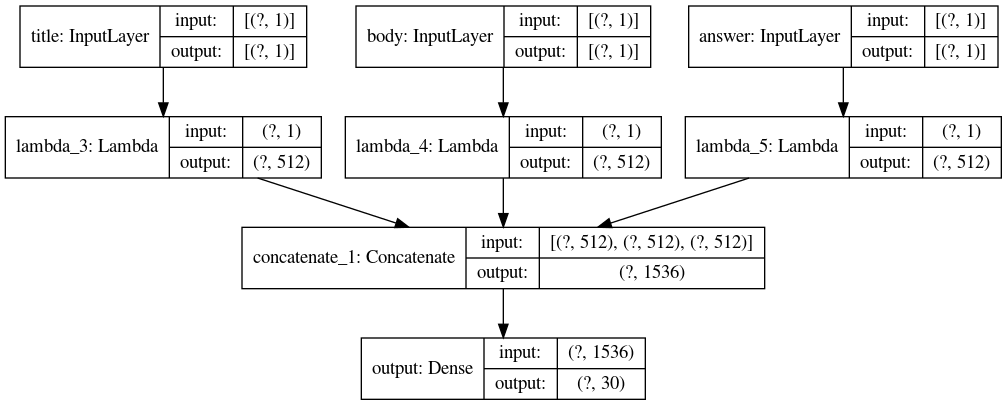

In [40]:
plot_model(model, to_file='model.png', show_shapes = True)

In [41]:
data = []
for c in tqdm(train.columns):
    data.append(train[c].values)

100%|██████████| 3/3 [00:00<00:00, 3454.00it/s]


In [ ]:
history = model.fit(train.values, Y.values, validation_split=0.2, shuffle=True, batch_size=64, epochs=3)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()